In [2]:
import pandas as pd
import os
import numpy as np
import string
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler

# Suppress TensorFlow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Load data
data = pd.read_csv("/content/drive/MyDrive/LSTM/output.csv")

data['input_text'] = data['title'] + " - " + data['content_original']
data = data.dropna(subset=['input_text'])

def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

data['input_text'] = data['input_text'].apply(preprocess_text)

# Encode labels (bias_text)
label_encoder = LabelEncoder()
data['bias_text_encoded'] = label_encoder.fit_transform(data['bias_text'])

# Split into train + validation and test sets (80% train + val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data['input_text'],
    data['bias_text_encoded'],
    test_size=0.2,
    random_state=123,
    stratify=data['bias_text_encoded']
)

# Split train + validation into separate train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,  # 0.2 of 80% = 16% of total data, 64% for train, 16% for validation
    random_state=123,
    stratify=y_train_val
)

# Tokenize the text data
max_words = 30000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

print(f"Training data shape: {X_train_pad.shape}")
print(f"Validation data shape: {X_val_pad.shape}")
print(f"Test data shape: {X_test_pad.shape}")

print("Training data class distribution:")
print(pd.Series(y_train).value_counts())

Training data shape: (24034, 500)
Validation data shape: (6009, 500)
Test data shape: (7511, 500)
Training data class distribution:
bias_text_encoded
2    8789
1    8323
0    6922
Name: count, dtype: int64


In [5]:
import numpy as np

# Load GloVe embeddings
def load_glove_embeddings(glove_file, embedding_dim=100):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_file = '/content/drive/MyDrive/LSTM/glove.6B.100d.txt'

embeddings_index = load_glove_embeddings(glove_file, embedding_dim=100)

embedding_matrix = np.zeros((max_words + 1, 100))  # Shape: (max_words + 1, embedding_dim)
for word, i in tokenizer.word_index.items():

    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            # Initialize missing words with random values
            embedding_matrix[i] = np.random.randn(100)

# Add a zero vector for the padding token (index 0)
embedding_matrix[0] = np.zeros(100)

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (30001, 100)


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

# Model parameters
embedding_dim = 100
lstm_units = 64
num_classes = len(label_encoder.classes_)
batch_size = 128
learning_rate = 0.001

# Define the model
model = Sequential([

    Embedding(input_dim=max_words + 1,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              trainable=False),

    Bidirectional(LSTM(units=lstm_units, return_sequences=True)),  # Bidirectional LSTM
    GlobalAveragePooling1D(),  # Pooling layer to reduce dimensionality
    Dropout(0.3),  # Dropout for regularization
    Dense(32, activation='relu'),  # Reduced Dense layer size
    Dropout(0.3),  # Dropout for regularization
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class classification
])

model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       3,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,000,100 (11.44 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,000,100 (11.44 MB)

In [ ]:
history = model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=batch_size,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping]
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.3601 - loss: 1.0969 - val_accuracy: 0.3660 - val_loss: 1.0880
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.3920 - loss: 1.0825 - val_accuracy: 0.4397 - val_loss: 1.0628
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.4489 - loss: 1.0523 - val_accuracy: 0.4984 - val_loss: 1.0048
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.4933 - loss: 1.0049 - val_accuracy: 0.5467 - val_loss: 0.9100
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - accuracy: 0.5433 - loss: 0.9357 - val_accuracy: 0.5668 - val_loss: 0.8831
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5871 - loss: 0.8878 - val_accuracy: 0.6021 - val_loss: 0.8395
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6036 - loss: 0.8537 - val_accuracy: 0.4853 - val_loss: 0.9771
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.5451 - loss: 0.9492 - v

In [ ]:
from sklearn.metrics import classification_report, f1_score

y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=1)  # Convert probabilities to class labels

f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"F1 Score: {f1}")

class_names = label_encoder.classes_
report = classification_report(y_test, y_pred_classes, target_names=class_names)
print(report)

235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 56ms/step
F1 Score: 0.7167804722303867
              precision    recall  f1-score   support

      center       0.84      0.64      0.73      2163
        left       0.62      0.76      0.68      2601
       right       0.75      0.73      0.74      2747

    accuracy                           0.72      7511
   macro avg       0.74      0.71      0.72      7511
weighted avg       0.73      0.72      0.72      7511



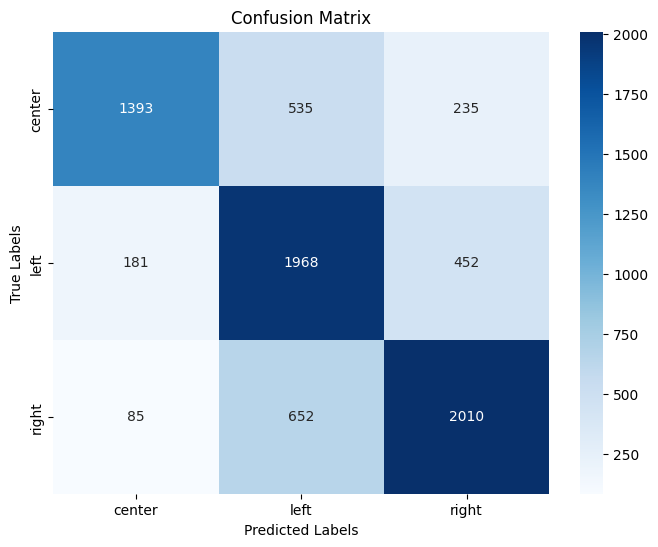

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [9]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import string

def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

# Function to predict the bias of a new article
def predict_bias(article, tokenizer, model, max_words=30000, max_len=500):
    # Step 1: Preprocess the article text
    article = preprocess_text(article)

    # Step 2: Tokenize the text (using the same tokenizer from training)
    article_seq = tokenizer.texts_to_sequences([article])

    # Step 3: Pad the sequence to match the input length expected by the model
    article_pad = pad_sequences(article_seq, maxlen=max_len)

    # Step 4: Make the prediction
    prediction = model.predict(article_pad)

    # Step 5: Get the predicted class
    predicted_class = prediction.argmax(axis=1)[0]

    # Step 6: Map the predicted class back to the label (bias_text_encoded)
    predicted_label = label_encoder.classes_[predicted_class]

    return predicted_label

new_article = """

New York police are investigating a fatal immigrant gang stabbing in Lower Manhattan that left one teenager dead and another injured.

The stabbing is believed to have erupted because of a dispute between migrant gangs that have taken over several New York City-run migrant hotels in the neighborhood, according to local news channel ABC7 NY.

The two victims, both teenage migrants reportedly associated with a Venezuelan gang called "Los Diablos de la 42" (the devils of 42nd Street), were attacked by three unknown assailants at 7:43 p.m. on Dec. 5.

The deceased victim, a 17-year-old named Yeremi Colino, was living in the Roosevelt Hotel in Midtown Manhattan, which is being used as a migrant shelter paid for by the City of New York. Colino was stabbed in the chest and was taken to a nearby hospital after a bystander called 911. Colino died from his wounds in the hospital.

The second victim, an 18-year-old migrant named Alan Magalles Bello, was stabbed in the arm by a screwdriver but is expected to recover.

The three assailants, who were wearing COVID masks, were caught on camera. Police have yet to make any arrests.

The incident was initially being investigated as a hate crime as early reports indicated the assailants attacked after asking the two victims if they spoke English. Several Democratic politicians rushed to condemn the attack as "racist."

According to local outlet amNewYork Metro, Congressman Dan Goldman, whose district includes portions of Manhattan, said that "two migrant teenagers were stabbed in our city because they didn’t speak English."

"I condemn this racist, xenophobic hatred in the strongest terms – it has no place in our city and must be rejected," he said, adding that "these suspects must be prosecuted to the fullest extent of the law."

Police are no longer investigating the attack as a hate crime, however, after video footage indicated the confrontation unfolded over gang signs.

According to ABC7 NY, video footage recorded the victims confronting the larger group asking; "Why are you flashing gang signs?" before a brawl ensued, which left Colino dead and Bello injured.

The New York Post reported that both victims were associated with the "Diablos de la 42" gang, which has ties to the international Venezuelan terrorist group "Tren de Aragua."

ABC7 NY reported that the suspects are believed to be gang members in the Caribbean migrant community.

New York Police Department Detective Bureau Assistant Chief Jason Savino said that the Diablos gang has issued messages mourning the loss of Colino and vowing revenge on the Caribbean gang.

"""

# Make a prediction
predicted_bias = predict_bias(new_article, tokenizer, model)

print(f"The predicted bias for the article is: {predicted_bias}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
The predicted bias for the article is: right
